In [1]:
import os
import sys

if 'SPARK_HOME' not in os.environ:
    os.environ['SPARK_HOME'] = "/usr/bin/spark-3.0.0-preview2-bin-hadoop2.7"
if 'PYSPARK_PYTHON' not in os.environ:
    os.environ['PYSPARK_PYTHON'] = "/usr/bin/python3"
    
    
SPARK_HOME = os.environ['SPARK_HOME']

sys.path.insert(0,  os.path.join(SPARK_HOME, 'python'))
sys.path.insert(0, os.path.join(SPARK_HOME, 'python', 'lib'))
sys.path.insert(0, os.path.join(SPARK_HOME, 'python', 'lib', 'pyspark.zip'))
sys.path.insert(0, os.path.join(SPARK_HOME, 'python', 'lib', 'py4j-0.10.8.1-src.zip'))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from bs4 import BeautifulSoup

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

pd.set_option('display.max_colwidth', -1)

In [3]:
cols = ['sentiment', 'id', 'date', 'query_string', 'user', 'text']
tweets = pd.read_csv("./training.1600000.processed.noemoticon.csv", 
                 header=None,
                 names=cols,
                 encoding="ISO-8859-1"
                )

In [4]:
tweets.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [5]:
tweets['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [7]:
tweets.drop(columns=['id', 'date', 'query_string', 'user'], axis=1, inplace=True)

In [8]:
tweets[tweets['sentiment'] == 0].head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [9]:
tweets[tweets['sentiment'] == 4].head()

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart."
800003,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup"
800004,4,@LovesBrooklyn2 he has that effect on everyone


In [10]:
tweets['pre_clean_len'] = [len(t) for t in tweets['text']]

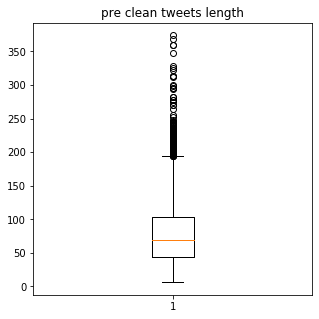

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(tweets['pre_clean_len'])
plt.title('pre clean tweets length')
plt.show()

In [12]:
# data cleaning

def tweet_cleaner(text):
    
    # 1. first step is to decode html tags to general tags.
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    
    # 2. remove @mention handles 
    handle_pat = r'@[A-Za-z0-9_]+'
    han_rem = re.sub(handle_pat, '', souped)
    
    # 3. remove http url
    url_pat = r'https?://[A-Za-z0-9./]+'
    url_rem = re.sub(url_pat, '', han_rem)
    
    # 4. remove www url
    www_pat = r'www.[^ ]+'
    www_rem = re.sub(www_pat, '', url_rem)
    
    # 5. decode the text with 'utf-8-sig' , to remove utf-8 BOM sequence (\xef\xbf\xbd).
    try:
        cleaned_text = www_rem.decode('utf-8-sig').replace(u'\ufffd', '?')
    except:
        cleaned_text = www_rem
        
    # 6. handle negation words( can't -> can not)
    neg_handeled = re.sub(r"won't", 'will not', cleaned_text)
    neg_handeled = re.sub(r"can't", 'can not', neg_handeled)
    neg_handeled = re.sub(r"n't", ' not', neg_handeled)
        
    # 7. remove special chars
    text_only = re.sub('[^A-Za-z]', ' ', neg_handeled)
    
    # 8. covert text to lower case and remove unwanted space added by above step
    low_text = text_only.lower()
    final_text = low_text.split()
    
    return (' '.join(final_text))
    
    

In [13]:
cleaned_tweets_text = []
batch = 100000
for i in range(len(tweets)):
    if i > 0 and i % batch == 0 :
        print(f'processed {i} tweets')
    cleaned_tweets_text.append(tweet_cleaner(tweets['text'][i]))

processed 100000 tweets
processed 200000 tweets
processed 300000 tweets
processed 400000 tweets
processed 500000 tweets
processed 600000 tweets
processed 700000 tweets
processed 800000 tweets
processed 900000 tweets
processed 1000000 tweets
processed 1100000 tweets
processed 1200000 tweets
processed 1300000 tweets
processed 1400000 tweets
processed 1500000 tweets


In [14]:
cleaned_tweets = pd.DataFrame(cleaned_tweets_text, columns=['text'])
cleaned_tweets['target'] = tweets['sentiment']
cleaned_tweets.head(20)

,text,target
0,awww that s a bummer you shoulda got david carr of third day to do it d,0
1,is upset that he can not update his facebook by texting it and might cry as a result school today also blah,0
2,i dived many times for the ball managed to save the rest go out of bounds,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i here because i can not see you all over there,0
5,not the whole crew,0
6,need a hug,0
7,hey long time no see yes rains a bit only a bit lol i m fine thanks how s you,0
8,nope they did not have it,0
9,que me muera,0


In [15]:
cleaned_tweets.isnull().values.any()

False

In [16]:
cleaned_tweets['length'] = cleaned_tweets['text'].str.split().apply(len)

In [17]:
cleaned_tweets.head()

,text,target,length
0,awww that s a bummer you shoulda got david carr of third day to do it d,0,17
1,is upset that he can not update his facebook by texting it and might cry as a result school today also blah,0,22
2,i dived many times for the ball managed to save the rest go out of bounds,0,16
3,my whole body feels itchy and like its on fire,0,10
4,no it s not behaving at all i m mad why am i here because i can not see you all over there,0,23


In [37]:
cleaned_tweets.to_csv('cleaned_tweets.csv', encoding='utf-8')

In [3]:
spark = SparkSession \
        .builder \
        .appName('TweetsAnalyzer') \
        .getOrCreate()

In [4]:
tweets_df = spark.read.csv("cleaned_tweets.csv", header=True)

In [5]:
tweets_df.count()

1600000

In [6]:
tweets_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- text: string (nullable = true)
 |-- target: string (nullable = true)
 |-- length: string (nullable = true)



In [7]:
tweets_df.show()

+---+--------------------+------+------+
|_c0|                text|target|length|
+---+--------------------+------+------+
|  0|awww that s a bum...|     0|    17|
|  1|is upset that he ...|     0|    22|
|  2|i dived many time...|     0|    16|
|  3|my whole body fee...|     0|    10|
|  4|no it s not behav...|     0|    23|
|  5|  not the whole crew|     0|     4|
|  6|          need a hug|     0|     3|
|  7|hey long time no ...|     0|    20|
|  8|nope they did not...|     0|     6|
|  9|        que me muera|     0|     3|
| 10|spring break in p...|     0|     8|
| 11|i just re pierced...|     0|     6|
| 12|i could not bear ...|     0|    15|
| 13|it it counts idk ...|     0|    14|
| 14|i would ve been t...|     0|    22|
| 15|i wish i got to w...|     0|    17|
| 16|hollis death scen...|     0|    18|
| 17| about to file taxes|     0|     4|
| 18|ahh ive always wa...|     0|    10|
| 19|oh dear were you ...|     0|    11|
+---+--------------------+------+------+
only showing top

In [8]:
tweets_df.filter("text is null").count()

3749

In [9]:
tweets_df = tweets_df.dropna()

In [10]:
tweets_df.count()

1596251

In [11]:
# split the data in train, val and test sets
(train_set, val_set, test_set) = tweets_df.randomSplit([0.98, 0.01, 0.01], seed=40)

In [12]:
print(f"train data : {train_set.count()} \nval data : {val_set.count()} \ntest data : {test_set.count()}")

train data : 1564468 
val data : 15789 
test data : 15994


In [13]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features", minDocFreq=5)
label_stringIdx = StringIndexer(inputCol="target", outputCol="label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx, lr])

In [14]:
model = pipeline.fit(train_set)

In [15]:
val_pred = model.transform(val_set)

In [16]:
val_pred.show()

+------+--------------------+------+------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|   _c0|                text|target|length|               words|        raw_features|            features|label|       rawPrediction|         probability|prediction|
+------+--------------------+------+------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|100097|another stinking ...|     0|     3|[another, stinkin...|(65536,[16307,245...|(65536,[16307,245...|  0.0|[3.02997935437078...|[0.95391026527641...|       0.0|
|100117|finished work yay...|     0|     7|[finished, work, ...|(65536,[5877,8709...|(65536,[5877,8709...|  0.0|[0.89484455413591...|[0.70988890582443...|       0.0|
|100129|why am i always i...|     0|     9|[why, am, i, alwa...|(65536,[9408,1424...|(65536,[9408,1424...|  0.0|[1.86205098113115...|[0.86553582753692...|       0.0|
|100

In [17]:
val_pred.select("text", "label", "prediction", "rawPrediction").show(20, False)

+-----------------------------------------------------------------------------------------------------------------------------------+-----+----------+------------------------------------------+
|text                                                                                                                               |label|prediction|rawPrediction                             |
+-----------------------------------------------------------------------------------------------------------------------------------+-----+----------+------------------------------------------+
|another stinking migraine                                                                                                          |0.0  |0.0       |[3.0299793543707803,-3.0299793543707803]  |
|finished work yay time for assignments boo                                                                                         |0.0  |0.0       |[0.8948445541359162,-0.8948445541359162]  |
|why am i always ill it drives

In [18]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction')
evaluator.evaluate(val_pred)

0.7899366175535865

In [19]:
accuracy = val_pred.filter(val_pred.label == val_pred.prediction).count() / float(val_set.count())
accuracy

0.7900437013110393

In [20]:
model.save('tweets_analyzer.model')